## Installs

In [1]:
!nvidia-smi

Tue Oct 24 14:37:43 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.54.03              Driver Version: 535.54.03    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A5500               Off | 00000000:3B:00.0 Off |                  Off |
| 30%   30C    P8              16W / 230W |  22542MiB / 24564MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Imports

In [36]:
import os
import sys
import time
import glob
import itertools
import pathlib
from pathlib import Path
from ast import literal_eval
from collections import OrderedDict
import keras
import cv2
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from PIL import Image
import openslide
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, normalize
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, mean_absolute_error, mean_squared_error, r2_score, mean_squared_log_error, recall_score, f1_score, accuracy_score, cohen_kappa_score, precision_score, jaccard_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from sklearn.metrics import pairwise_distances

import tensorflow as tf
from keras import optimizers, losses, metrics
from keras.layers import Conv2D, Resizing, InputLayer, Flatten, Dense, Input
from keras.models import Sequential, Model

from histoprep import SlideReader


In [3]:
num_classes = 2
init_lr = 1e-4
warmup_factor = 10
n_epochs = 15
warmup_epo = 1
batch_size = 64
num_workers = 2
debug = False
patch_size = (192,192)

In [6]:

data_dir = '/root/data/KDM/urkunina_hun_slides'
image_folder = f'{data_dir}/slides_urkunina/'
mask_folder = f'{data_dir}/train_label_masks/'
df = pd.read_csv("/root/data/KDM/urkunina_hun_slides/val_0_1234.csv", delimiter=';', header=None)


In [7]:
df

,0,1
0,H013,0
1,H016,1
2,H021,1
3,H022,1
4,H026,0
5,H036,0
6,U007,1
7,U016,1
8,U025,1
9,U031,0


### WSI to extract patches from

In [11]:
img_name = 'U032'

In [16]:
def get_thumbnail(slide):
  wsi = openslide.OpenSlide(os.path.join(image_folder, f"{slide}.svs"))
  thumb = wsi.get_thumbnail((wsi.dimensions[0] // 16, wsi.dimensions[1] // 16))
  thumb.save(os.path.join('/root/data/KDM/upper-GI-KDM/heatmaps', f"{slide}_thumbnail.png"))
  wsi.close()
  return np.asarray(thumb)

### Check thumbnail before extraction

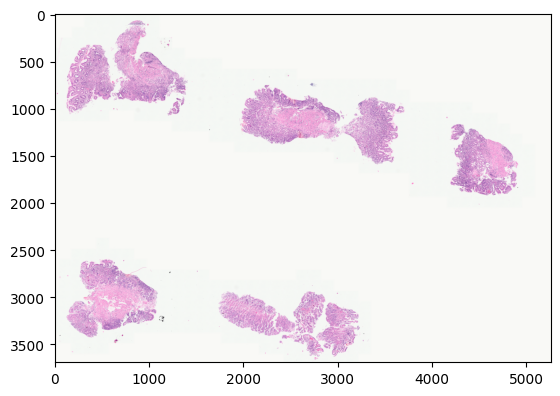

In [17]:
plt.imshow(get_thumbnail(img_name))

In [29]:
reader = SlideReader(os.path.join(image_folder,img_name+".svs"))
# Detect tissue.
threshold, tissue_mask = reader.get_tissue_mask(level=1)
# Extract overlapping tile coordinates with less than 50% background.
tile_coordinates = reader.get_tile_coordinates(
    tissue_mask, width=192, overlap=0, max_background=0.4
)

coords = tile_coordinates.coordinates
#adjusted_coords = adjust_coordinates_for_level(coords, level=1)
slide = openslide.OpenSlide(os.path.join(image_folder, img_name + ".svs"))
output_dir = os.path.join("/root/data/KDM/tiles_for_viz", img_name)
os.makedirs(output_dir, exist_ok=True)

# Loop through adjusted coordinates to extract and save patches
for x, y, w, h in coords:
    # Extract the patch using OpenSlide
    patch = slide.read_region((x, y), 1, (w, h))
    patch_rgb = patch.convert("RGB")
    # Save the patch with the specified naming convention
    patch_file_name = f"x{x}_y{y}_w{w}_h{h}.jpeg"
    patch_file_path = os.path.join(output_dir, patch_file_name)
    patch_rgb.save(patch_file_path)


# tile_metadata = reader.save_regions(
#     "/root/data/KDM/tiles_for_viz",
#     tile_coordinates,
#     threshold=threshold,
#     save_metrics=True,
#     overwrite=True,
# )

In [30]:
folder_path = f'/root/data/KDM/tiles_for_viz/{img_name}'

# Extracting all file names with the .jpeg extension
patch_files = [f for f in os.listdir(folder_path) if f.endswith('.jpeg')]

# Extracting the image_id and coords
data = []
for file_name in patch_files:
    x_coord = int(file_name.split('_')[0][1:])
    y_coord = int(file_name.split('_')[1][1:])
    data.append((file_name, (x_coord, y_coord)))

# Creating the DataFrame
df_patch = pd.DataFrame(data, columns=['image_id', 'coords'])


In [32]:
df_patch

,image_id,coords
0,x11136_y12096_w192_h192.jpeg,"(11136, 12096)"
1,x7296_y47424_w192_h192.jpeg,"(7296, 47424)"
2,x38592_y14976_w192_h192.jpeg,"(38592, 14976)"
3,x41088_y15936_w192_h192.jpeg,"(41088, 15936)"
4,x6336_y6528_w192_h192.jpeg,"(6336, 6528)"
...,...,...
11646,x43200_y17856_w192_h192.jpeg,"(43200, 17856)"
11647,x73728_y21312_w192_h192.jpeg,"(73728, 21312)"
11648,x7104_y45120_w192_h192.jpeg,"(7104, 45120)"
11649,x52608_y22272_w192_h192.jpeg,"(52608, 22272)"


In [16]:
data_dir = f"/root/data/QKM/data/visualization/tiles/{img_name}/tiles"

In [37]:
def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return img

def process_path(file_path):

  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img

### Get predictions from end to end model

In [39]:
encoded_size = 128
n_comp = 4

class Patches(tf.keras.layers.Layer):
    def __init__(self, patch_size, image_size, strides):
        super(Patches, self).__init__()
        self.patch_size = patch_size
        self.strides = strides
        self.num_patches = (image_size - patch_size) // strides + 1

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.strides, self.strides, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, self.num_patches ** 2, patch_dims])
        return patches

def dm2comp(dm):
    '''
    Extract vectors and weights from a factorized density matrix representation
    Arguments:
     dm: tensor of shape (bs, n, d + 1)
    Returns:
     w: tensor of shape (bs, n)
     v: tensor of shape (bs, n, d)
    '''
    return dm[:, :, 0], dm[:, :, 1:]


def comp2dm(w, v):
    '''
    Construct a factorized density matrix from vectors and weights
    Arguments:
     w: tensor of shape (bs, n)
     v: tensor of shape (bs, n, d)
    Returns:
     dm: tensor of shape (bs, n, d + 1)
    '''
    return tf.concat((w[:, :, tf.newaxis], v), axis=2)

def samples2dm(samples):
    '''
    Construct a factorized density matrix from a batch of samples
    each sample will have the same weight. Samples that are all
    zero will be ignored.
    Arguments:
        samples: tensor of shape (bs, n, d)
    Returns:
        dm: tensor of shape (bs, n, d + 1)
    '''
    w = tf.reduce_any(samples, axis=-1)
    w = w / tf.reduce_sum(w, axis=-1, keepdims=True)
    return comp2dm(w, samples)

def pure2dm(psi):
    '''
    Construct a factorized density matrix to represent a pure state
    Arguments:
     psi: tensor of shape (bs, d)
    Returns:
     dm: tensor of shape (bs, 1, d + 1)
    '''
    ones = tf.ones_like(psi[:, 0:1])
    dm = tf.concat((ones[:,tf.newaxis, :],
                    psi[:,tf.newaxis, :]),
                   axis=2)
    return dm


def dm2discrete(dm):
    '''
    Creates a discrete distribution from the components of a density matrix
    Arguments:
     dm: tensor of shape (bs, n, d + 1)
    Returns:
     prob: vector of probabilities (bs, d)
    '''
    w, v = dm2comp(dm)
    w = w / tf.reduce_sum(w, axis=-1, keepdims=True)
    norms_v = tf.expand_dims(tf.linalg.norm(v, axis=-1), axis=-1)
    v = v / norms_v
    probs = tf.einsum('...j,...ji->...i', w, v ** 2, optimize="optimal")
    return probs


# def dm2distrib(dm, sigma):
#     '''
#     Creates a Gaussian mixture distribution from the components of a density
#     matrix with an RBF kernel
#     Arguments:
#      dm: tensor of shape (bs, n, d + 1)
#      sigma: sigma parameter of the RBF kernel
#     Returns:
#      gm: mixture of Gaussian distribution with shape (bs, )
#     '''
#     w, v = dm2comp(dm)
#     gm = tfd.MixtureSameFamily(reparameterize=True,
#             mixture_distribution=tfd.Categorical(
#                                     probs=w),
#             components_distribution=tfd.Independent( tfd.Normal(
#                     loc=v,  # component 2
#                     scale=sigma / np.sqrt(2.)),
#                     reinterpreted_batch_ndims=1))
#     return gm


def pure_dm_overlap(x, dm, kernel):
    '''
    Calculates the overlap of a state  \phi(x) with a density
    matrix in a RKHS defined by a kernel
    Arguments:
      x: tensor of shape (bs, d)
     dm: tensor of shape (bs, n, d + 1)
     kernel: kernel function
              k: (bs, d) x (bs, n, d) -> (bs, n)
    Returns:
     overlap: tensor with shape (bs, )
    '''
    w, v = dm2comp(dm)
    overlap = tf.einsum('...i,...i->...', w, kernel(x, v) ** 2)
    return overlap

## Kernels

class CompTransKernelLayer(tf.keras.layers.Layer):
    def __init__(self, transform, kernel):
        '''
        Composes a transformation and a kernel to create a new
        kernel.
        Arguments:
            transform: a function f that transform the input before feeding it to the
                    kernel
                    f:(bs, d) -> (bs, D)
            kernel: a kernel function
                    k:(bs, n, D)x(m, D) -> (bs, n, m)
        '''
        super(CompTransKernelLayer, self).__init__()
        self.transform = transform
        self.kernel = kernel

    def call(self, A, B):
        '''
        Input:
            A: tensor of shape (bs, n, d)
            B: tensor of shape (m, d)
        Result:
            K: tensor of shape (bs, n, m)
        '''
        shape = tf.shape(A) # (bs, n, d)
        A = tf.reshape(A, [shape[0] * shape[1], shape[2]])
        A = self.transform(A)
        dim_out = tf.shape(A)[1]
        A = tf.reshape(A, [shape[0], shape[1], dim_out])
        B = self.transform(B)
        return self.kernel(A, B)

    def log_weight(self):
        return self.kernel.log_weight()

class RBFKernelLayer(tf.keras.layers.Layer):
    def __init__(self, sigma, dim, trainable=True, min_sigma=1e-3):
        '''
        Builds a layer that calculates the rbf kernel between two set of vectors
        Arguments:
            sigma: RBF scale parameter. If it is a tf.Variable it will be used as is.
                     Otherwise it will create a trainable variable with the given value.
        '''
        super(RBFKernelLayer, self).__init__()
        if type(sigma) is tf.Variable:
            self.sigma = sigma
        else:
            self.sigma = tf.Variable(sigma, dtype=tf.float32, trainable=trainable)
        self.dim = dim
        self.min_sigma = min_sigma

    def call(self, A, B):
        '''
        Input:
            A: tensor of shape (bs, n, d)
            B: tensor of shape (m, d)
        Result:
            K: tensor of shape (bs, n, m)
        '''
        shape_A = tf.shape(A)
        shape_B = tf.shape(B)
        A_norm = tf.norm(A, axis=-1)[..., tf.newaxis] ** 2
        B_norm = tf.norm(B, axis=-1)[tf.newaxis, tf.newaxis, :] ** 2
        A_reshaped = tf.reshape(A, [-1, shape_A[2]])
        AB = tf.matmul(A_reshaped, B, transpose_b=True)
        AB = tf.reshape(AB, [shape_A[0], shape_A[1], shape_B[0]])
        dist2 = A_norm + B_norm - 2. * AB
        dist2 = tf.clip_by_value(dist2, 0., np.inf)
        sigma = tf.clip_by_value(self.sigma, self.min_sigma, np.inf)
        K = tf.exp(-dist2 / (2. * sigma ** 2.))
        return K

    def log_weight(self):
        sigma = tf.clip_by_value(self.sigma, self.min_sigma, np.inf)
        return - self.dim * tf.math.log(sigma + 1e-12) - self.dim * np.log(4 * np.pi)



'''
Keras layer version of CosineKernel
'''
class CosineKernelLayer(tf.keras.layers.Layer):
    def __init__(self):
        '''
        Builds a layer that calculates the cosine kernel between two set of vectors
        '''
        super(CosineKernelLayer, self).__init__()
        self.eps = 1e-6

    def call(self, A, B):
        '''
        Input:
            A: tensor of shape (bs, n, d)
            B: tensor of shape (m, d)
        Result:
            K: tensor of shape (bs, n, m)
        '''
        A = tf.math.divide_no_nan(A,
                                  tf.expand_dims(tf.norm(A, axis=-1), axis=-1))
        B = tf.math.divide_no_nan(B,
                                  tf.expand_dims(tf.norm(B, axis=-1), axis=-1))
        K = tf.einsum("...nd,md->...nm", A, B)
        return K

    def log_weight(self):
        return 0


class CrossProductKernelLayer(tf.keras.layers.Layer):

    def __init__(self, dim1, kernel1, kernel2):
        '''
        Create a layer that calculates the cross product kernel of two input
        kernels. The input vector are divided into two parts, the first of dimension
        dim1 and the second of dimension d - dim1. Each input kernel is applied to
        one of the parts of the input.
        Arguments:
            dim1: the dimension of the first part of the input vector
            kernel1: a kernel function
                    k1:(bs, n, dim1)x(m, dim1) -> (bs, n, m)
            kernel2: a kernel function
                    k2:(bs, n, d - dim1)x(m, d - dim1) -> (bs, n, m)
        '''

        super(CrossProductKernelLayer, self).__init__()
        self.dim1 = dim1
        self.kernel1 = kernel1
        self.kernel2 = kernel2

    def call(self, A, B):
        '''
        Input:
            A: tensor of shape (bs, n, d)
            B: tensor of shape (m, d)
        Result:
            K: tensor of shape (bs, n, m)
        '''
        A1 = A[:, :, :self.dim1]
        A2 = A[:, :, self.dim1:]
        B1 = B[:, :self.dim1]
        B2 = B[:, self.dim1:]
        return self.kernel1(A1, B1) * self.kernel2(A2, B2)

    def log_weight(self):
        return self.kernel1.log_weight() + self.kernel2.log_weight()

## Layers and models

def l1_loss(vals):
    '''
    Calculate the l1 loss for a batch of vectors
    Arguments:
        vals: tensor with shape (b_size, n)
    '''
    b_size = tf.cast(tf.shape(vals)[0], dtype=tf.float32)
    vals = vals / tf.norm(vals, axis=1)[:, tf.newaxis]
    loss = tf.reduce_sum(tf.abs(vals)) / b_size
    return loss

class KQMUnit(tf.keras.layers.Layer):
    """Kernel Quantum Measurement Unit
    Receives as input a factored density matrix represented by a set of vectors
    and weight values.
    Returns a resulting factored density matrix.
    Input shape:
        (batch_size, n_comp_in, dim_x + 1)
        where dim_x is the dimension of the input state
        and n_comp_in is the number of components of the input factorization.
        The weights of the input factorization of sample i are [i, :, 0],
        and the vectors are [i, :, 1:dim_x + 1].
    Output shape:
        (batch_size, n_comp, dim_y)
        where dim_y is the dimension of the output state
        and n_comp is the number of components used to represent the train
        density matrix. The weights of the
        output factorization for sample i are [i, :, 0], and the vectors
        are [i, :, 1:dim_y + 1].
    Arguments:
        dim_x: int. the dimension of the input state
        dim_y: int. the dimension of the output state
        x_train: bool. Whether to train or not the x compoments of the train
                       density matrix.
        x_train: bool. Whether to train or not the y compoments of the train
                       density matrix.
        w_train: bool. Whether to train or not the weights of the compoments
                       of the train density matrix.
        n_comp: int. Number of components used to represent
                 the train density matrix
        l1_act: float. Coefficient of the regularization term penalizing the l1
                       norm of the activations.
        l1_x: float. Coefficient of the regularization term penalizing the l1
                       norm of the x components.
        l1_y: float. Coefficient of the regularization term penalizing the l1
                       norm of the y components.
    """
    def __init__(
            self,
            kernel,
            dim_x: int,
            dim_y: int,
            x_train: bool = True,
            y_train: bool = True,
            w_train: bool = True,
            n_comp: int = 0,
            l1_x: float = 0.,
            l1_y: float = 0.,
            l1_act: float = 0.,
            **kwargs
    ):
        super().__init__(**kwargs)
        self.kernel = kernel
        self.dim_x = dim_x
        self.dim_y = dim_y
        self.x_train = x_train
        self.y_train = y_train
        self.w_train = w_train
        self.n_comp = n_comp
        self.l1_x = l1_x
        self.l1_y = l1_y
        self.l1_act = l1_act
        self.c_x = self.add_weight(
            "c_x",
            shape=(self.n_comp, self.dim_x),
            #initializer=tf.keras.initializers.orthogonal(),
            initializer=tf.keras.initializers.random_normal(),
            trainable=self.x_train)
        self.c_y = self.add_weight(
            "c_y",
            shape=(self.n_comp, self.dim_y),
            initializer=tf.keras.initializers.Constant(np.sqrt(1./self.dim_y)),
            #initializer=tf.keras.initializers.random_normal(),
            trainable=self.y_train)
        self.comp_w = self.add_weight(
            "comp_w",
            shape=(self.n_comp,),
            initializer=tf.keras.initializers.constant(1./self.n_comp),
            trainable=self.w_train)
        self.eps = 1e-10

    def call(self, inputs):
        # Weight regularizers
        if self.l1_x != 0:
            self.add_loss(self.l1_x * l1_loss(self.c_x))
        if self.l1_y != 0:
            self.add_loss(self.l1_y * l1_loss(self.c_y))
        #comp_w = tf.clip_by_value(self.comp_w, 1e-10, 1)
        comp_w = tf.abs(self.comp_w) + 1e-6
        # normalize comp_w to sum to 1
        comp_w = comp_w / tf.reduce_sum(comp_w)
        in_w = inputs[:, :, 0]  # shape (b, n_comp_in)
        in_v = inputs[:, :, 1:] # shape (b, n_comp_in, dim_x)
        out_vw = self.kernel(in_v, self.c_x)  # shape (b, n_comp_in, n_comp)
        out_w = (tf.expand_dims(tf.expand_dims(comp_w, axis=0), axis=0) *
                 tf.square(out_vw)) # shape (b, n_comp_in, n_comp)
        out_w = tf.maximum(out_w, self.eps) #########
        # out_w_sum = tf.maximum(tf.reduce_sum(out_w, axis=2), self.eps)  # shape (b, n_comp_in)
        out_w_sum = tf.reduce_sum(out_w, axis=2) # shape (b, n_comp_in)
        out_w = out_w / tf.expand_dims(out_w_sum, axis=2)
        out_w = tf.einsum('...i,...ij->...j', in_w, out_w, optimize="optimal")
                # shape (b, n_comp)
        if self.l1_act != 0:
            self.add_loss(self.l1_act * l1_loss(out_w))
        out_w = tf.expand_dims(out_w, axis=-1) # shape (b, n_comp, 1)
        out_y_shape = tf.shape(out_w) + tf.constant([0, 0, self.dim_y - 1])
        out_y = tf.broadcast_to(tf.expand_dims(self.c_y, axis=0), out_y_shape)
        out = tf.concat((out_w, out_y), 2)
        return out

    def get_config(self):
        config = {
            "dim_x": self.dim_x,
            "dim_y": self.dim_y,
            "n_comp": self.n_comp,
            "x_train": self.x_train,
            "y_train": self.y_train,
            "w_train": self.w_train,
            "l1_x": self.l1_x,
            "l1_y": self.l1_y,
            "l1_act": self.l1_act,
        }
        base_config = super().get_config()
        return {**base_config, **config}

    def compute_output_shape(self, input_shape):
        return (self.dim_y + 1, self.n_comp)

class KQMOverlap(tf.keras.layers.Layer):
    """Kernel Quantum Measurement Overlap Unit
    Receives as input a vector and calculates its overlap with the unit density
    matrix.
    Input shape:
        (batch_size, dim_x)
        where dim_x is the dimension of the input state
    Output shape:
        (batch_size, )
    Arguments:
        kernel: a kernel function
        dim_x: int. the dimension of the input state
        x_train: bool. Whether to train the or not the compoments of the train
                       density matrix.
        w_train: bool. Whether to train the or not the weights of the compoments
                       of the train density matrix.
        n_comp: int. Number of components used to represent
                 the train density matrix
    """

    def __init__(
            self,
            kernel,
            dim_x: int,
            x_train: bool = True,
            w_train: bool = True,
            n_comp: int = 0,
            **kwargs
    ):
        super().__init__(**kwargs)
        self.kernel = kernel
        self.dim_x = dim_x
        self.x_train = x_train
        self.w_train = w_train
        self.n_comp = n_comp
        self.c_x = self.add_weight(
            "c_x",
            shape=(self.n_comp, self.dim_x),
            #initializer=tf.keras.initializers.orthogonal(),
            initializer=tf.keras.initializers.random_normal(),
            trainable=self.x_train)
        self.comp_w = self.add_weight(
            "comp_w",
            shape=(self.n_comp,),
            initializer=tf.keras.initializers.constant(1./self.n_comp),
            trainable=self.w_train)

    def call(self, inputs):
        #comp_w = tf.clip_by_value(self.comp_w, 1e-10, 1)
        comp_w = tf.abs(self.comp_w)
        # normalize comp_w to sum to 1
        comp_w = comp_w / tf.reduce_sum(comp_w)
        in_v = inputs[:, tf.newaxis, :]
        out_vw = self.kernel(in_v, self.c_x) ** 2 # shape (b, 1, n_comp)
        out_w = tf.einsum('...j,...ij->...', comp_w, out_vw, optimize="optimal")
        return out_w

    def get_config(self):
        config = {
            "dim_x": self.dim_x,
            "n_comp": self.n_comp,
            "x_train": self.x_train,
            "w_train": self.w_train,
        }
        base_config = super().get_config()
        return {**base_config, **config}

    def compute_output_shape(self, input_shape):
        return (1,)

class KQMClassModel(tf.keras.Model):
    def __init__(self,
                 dim_x,
                 dim_y,
                 sigma,
                 n_comp,
                 x_train=True):
        super().__init__()
        self.dim_x = dim_x
        self.dim_y = dim_y
        self.n_comp = n_comp
        self.kernel_x = RBFKernelLayer(sigma, dim=dim_x)
        self.kqmu = KQMUnit(self.kernel_x,
                            dim_x=dim_x,
                            dim_y=dim_y,
                            n_comp=n_comp,
                            x_train=x_train)

    def call(self, inputs):
        rho_x = pure2dm(inputs)
        rho_y = self.kqmu(rho_x)
        probs = dm2discrete(rho_y)
        return probs

class BagKQMClassModel(tf.keras.Model):
    def __init__(self,
                 dim_x,
                 dim_y,
                 sigma,
                 n_comp,
                 x_train=True,
                 l1_y=0.):
        super().__init__()
        self.dim_x = dim_x
        self.dim_y = dim_y
        self.n_comp = n_comp
        kernel_x = RBFKernelLayer(sigma)
        self.kqmu = KQMUnit(kernel_x,
                            dim_x=dim_x,
                            dim_y=dim_y,
                            n_comp=n_comp,
                            x_train=x_train,
                            l1_y=l1_y)

    def call(self, inputs):
        in_shape = tf.shape(inputs)
        w = tf.ones_like(inputs[:, :, 0]) / in_shape[1]
        rho_x = comp2dm(w, inputs)
        rho_y = self.kqmu(rho_x)
        probs = dm2discrete(rho_y)
        return rho_y

class KQMDenEstModel(tf.keras.Model):
    def __init__(self,
                 dim_x,
                 sigma,
                 n_comp):
        super().__init__()
        self.dim_x = dim_x
        self.n_comp = n_comp
        self.kernel = RBFKernelLayer(sigma, dim=dim_x)
        self.kqmover = KQMOverlap(self.kernel,
                                dim_x=dim_x,
                                n_comp=n_comp)

    def call(self, inputs):
        log_probs = (tf.math.log(self.kqmover(inputs) + 1e-12)
                     + self.kernel.log_weight())
        self.add_loss(-tf.reduce_mean(log_probs))
        return log_probs


class KQMDenEstModel2(tf.keras.Model):
    def __init__(self,
                 dim_x,
                 dim_y,
                 sigma,
                 n_comp,
                 trainable_sigma=True,
                 min_sigma=1e-3):
        super().__init__()
        self.dim_x = dim_x
        self.dim_y = dim_y
        self.n_comp = n_comp
        self.kernel_x = RBFKernelLayer(sigma, dim=dim_x,
                                       trainable=trainable_sigma,
                                       min_sigma=min_sigma)
        self.kernel_y = CosineKernelLayer()
        self.kernel = CrossProductKernelLayer(dim1=dim_x, kernel1=self.kernel_x, kernel2=self.kernel_y)
        self.kqmover = KQMOverlap(self.kernel,
                                dim_x=dim_x + dim_y,
                                n_comp=n_comp)

    def call(self, inputs):
        log_probs = (tf.math.log(self.kqmover(inputs) + 1e-12)
                     + self.kernel.log_weight())
        self.add_loss(-tf.reduce_mean(log_probs))
        return log_probs

class KQMAttentionLayer(tf.keras.layers.Layer):
    def __init__(self,
                 dim_h,
                 dense_units_1,
                 dense_units_2):
        super().__init__()
        self.dim_h = dim_h
        self.dense_units_1 = dense_units_1
        self.dense_units_2 = dense_units_2
        self.mlp_1 = tf.keras.Sequential([
                Dense(dense_units_1, activation='relu'),
                Dense(dim_h, activation='linear')])
        self.mlp_2 = tf.keras.Sequential([
                Dense(dense_units_2, activation='relu'),
                Dense(1, activation='linear')])
    def call(self, input):
        z_local = self.mlp_1(input)
        z_global = tf.reduce_mean(z_local, axis=1)
        z_global = tf.expand_dims(z_global, axis=1)

        z_global = tf.broadcast_to(z_global, tf.shape(z_local))
        z = tf.concat([z_local, z_global], axis=-1)
        z = self.mlp_2(z)
        z = tf.squeeze(z, axis=-1) # eliminate the last dimension which should be 1
        w = tf.nn.softmax(z) #aplicar sigmoid (cada uno de manera independiente) tf.math.sigmoid() - valores entre 0 y 1, normalizar los valores dividirlos por la suma de todos. atención mas variada
        return w

class KQMPatchClassModel(tf.keras.Model):
    def __init__(self,
                 patch_size,
                 image_size,
                 strides,
                 encoder,
                 encoded_size,
                 dim_y,
                 n_comp,
                 sigma=0.1,
                 attention=False,
                 attention_dim_h=64,
                 attention_dense_units_1=64,
                 attention_dense_units_2=64):
        super().__init__()
        self.patch_size = patch_size
        self.image_size = image_size
        self.strides = strides
        self.patch_layer = Patches(patch_size, image_size, strides)
        self.dim_y = dim_y
        self.encoded_size = encoded_size
        self.encoder = encoder
        self.n_comp = n_comp
        self.attention = attention
        self.kernel = RBFKernelLayer(sigma=sigma,
                                         dim=encoded_size,
                                         trainable=True)
        self.kqm_unit = KQMUnit(kernel=self.kernel,
                                       dim_x=encoded_size,
                                       dim_y=dim_y,
                                       n_comp=n_comp)
        if attention:
            self.attention_layer = KQMAttentionLayer(dim_h=attention_dim_h,
                                              dense_units_1=attention_dense_units_1,
                                              dense_units_2=attention_dense_units_2)
    def call(self, input): # (bs, 1152,1152,3)
        patches = self.patch_layer(input) #(bs, n_patches, w*h*c)
        encoded = self.encoder(patches) #()
        bs = tf.shape(encoded)[0]
        if self.attention:
            w = self.attention_layer(encoded)
        else:
            w = tf.ones((bs, self.patch_layer.num_patches ** 2,)) / (self.patch_layer.num_patches ** 2)
        rho_x = comp2dm(w, encoded)
        rho_y = self.kqm_unit(rho_x)
        probs = dm2discrete(rho_y)
        return probs

    def init_components(self, samples_x, samples_y, init_sigma=False, sigma_mult=1):
        patches = self.patch_layer(samples_x)
        idx = tf.random.uniform(shape=(patches.shape[0],), maxval=patches.shape[1], dtype=tf.int32) #select 1 random patch from each mosaic
        # Select the desired patches using tf.gather
        selected_patches = tf.gather(patches, idx, axis=1, batch_dims=1)
        # Encode the selected patches
        encoded_x = self.encoder(selected_patches[:, tf.newaxis, :])[:, 0, :]
        if init_sigma:
            distances = pairwise_distances(encoded_x)
            sigma = np.mean(distances) * sigma_mult
            self.kernel.sigma.assign(sigma)
        self.kqm_unit.c_x.assign(encoded_x)
        self.kqm_unit.c_y.assign(samples_y)
        self.kqm_unit.comp_w.assign(tf.ones((self.n_comp,)) / self.n_comp)

    def visualize_attention(self, input):
        patches = self.patch_layer(input)
        encoded = self.encoder(patches)
        w = self.attention_layer(encoded)
        conv2dt = tf.keras.layers.Conv2DTranspose(filters=1,
            kernel_size=self.patch_layer.patch_size,
            strides=self.patch_layer.strides,
            kernel_initializer=tf.keras.initializers.Ones(),
            bias_initializer=tf.keras.initializers.Zeros(),
            trainable=False)
        w = tf.reshape(w, [-1,
            self.patch_layer.num_patches,
            self.patch_layer.num_patches, 1])
        out = conv2dt(w)
        return out

def create_convnext_encoder(encoded_size):
  convnext = tf.keras.applications.convnext.ConvNeXtTiny(
    model_name='convnext_tiny',
    include_top=False,
    include_preprocessing=True,
    weights='imagenet',
    input_tensor=None,
    input_shape=(192,192,3),
    pooling="avg",
    classes=2,
    classifier_activation='softmax'
  )
  encoder = keras.Sequential([
      Input(shape=(192, 192, 3)),
      convnext,
      keras.layers.Dropout(0.2),
      keras.layers.Dense(encoded_size, activation="relu"), #relu, linear
  ])

  return encoder

class KQMSigmoidAttentionLayer(tf.keras.layers.Layer):
    def __init__(self,
                 dim_h,
                 dense_units_1,
                 dense_units_2):
        super().__init__()
        self.dim_h = dim_h
        self.dense_units_1 = dense_units_1
        self.dense_units_2 = dense_units_2
        self.mlp_1 = tf.keras.Sequential([
                Dense(dense_units_1, activation='relu'),
                Dense(dim_h, activation='linear')])
        self.mlp_2 = tf.keras.Sequential([
                Dense(dense_units_2, activation='relu'),
                Dense(1, activation='linear')])

    def call(self, input):
        z_local = self.mlp_1(input)
        z_global = tf.reduce_mean(z_local, axis=1)
        z_global = tf.expand_dims(z_global, axis=1)

        z_global = tf.broadcast_to(z_global, tf.shape(z_local))
        z = tf.concat([z_local, z_global], axis=-1)
        z = self.mlp_2(z)
        z = tf.squeeze(z, axis=-1)

        w = tf.nn.sigmoid(z) # Apply sigmoid to make weights independent
        w = w / tf.reduce_sum(w, axis=-1, keepdims=True) # Normalize the weights so they sum up to 1
        return w

class KQMSigmoidAttnPatchClassModel(tf.keras.Model):
    def __init__(self,
                 patch_size,
                 image_size,
                 strides,
                 encoder,
                 encoded_size,
                 dim_y,
                 n_comp,
                 sigma=0.1,
                 attention=False,
                 attention_dim_h=64,
                 attention_dense_units_1=64,
                 attention_dense_units_2=64):
        super().__init__()
        self.patch_size = patch_size
        self.image_size = image_size
        self.strides = strides
        self.patch_layer = Patches(patch_size, image_size, strides)
        self.dim_y = dim_y
        self.encoded_size = encoded_size
        self.encoder = encoder
        self.n_comp = n_comp
        self.attention = attention
        self.kernel = RBFKernelLayer(sigma=sigma,
                                         dim=encoded_size,
                                         trainable=True)
        self.kqm_unit = KQMUnit(kernel=self.kernel,
                                       dim_x=encoded_size,
                                       dim_y=dim_y,
                                       n_comp=n_comp)
        if attention:
            self.attention_layer = KQMSigmoidAttentionLayer(dim_h=attention_dim_h,
                                              dense_units_1=attention_dense_units_1,
                                              dense_units_2=attention_dense_units_2)
    def call(self, input): # (bs, 1152,1152,3)
        patches = self.patch_layer(input) #(bs, n_patches, w*h*c)
        encoded = self.encoder(patches) #()
        bs = tf.shape(encoded)[0]
        if self.attention:
            w = self.attention_layer(encoded)
        else:
            w = tf.ones((bs, self.patch_layer.num_patches ** 2,)) / (self.patch_layer.num_patches ** 2)
        rho_x = comp2dm(w, encoded)
        rho_y = self.kqm_unit(rho_x)
        probs = dm2discrete(rho_y)
        return probs

    def init_components(self, samples_x, samples_y, init_sigma=False, sigma_mult=1):
        patches = self.patch_layer(samples_x)
        idx = tf.random.uniform(shape=(patches.shape[0],), maxval=patches.shape[1], dtype=tf.int32) #select 1 random patch from each mosaic
        # Select the desired patches using tf.gather
        selected_patches = tf.gather(patches, idx, axis=1, batch_dims=1)
        # Encode the selected patches
        encoded_x = self.encoder(selected_patches[:, tf.newaxis, :])[:, 0, :]
        if init_sigma:
            distances = pairwise_distances(encoded_x)
            sigma = np.mean(distances) * sigma_mult
            self.kernel.sigma.assign(sigma)
        self.kqm_unit.c_x.assign(encoded_x)
        self.kqm_unit.c_y.assign(samples_y)
        self.kqm_unit.comp_w.assign(tf.ones((self.n_comp,)) / self.n_comp)

    def visualize_attention(self, input):
        patches = self.patch_layer(input)
        encoded = self.encoder(patches)
        w = self.attention_layer(encoded)
        conv2dt = tf.keras.layers.Conv2DTranspose(filters=1,
            kernel_size=self.patch_layer.patch_size,
            strides=self.patch_layer.strides,
            kernel_initializer=tf.keras.initializers.Ones(),
            bias_initializer=tf.keras.initializers.Zeros(),
            trainable=False)
        w = tf.reshape(w, [-1,
            self.patch_layer.num_patches,
            self.patch_layer.num_patches, 1])
        out = conv2dt(w)
        return out

class Encoder(keras.Model):

  def __init__(self, encoder):
    super().__init__()
    self.encoded_size = encoded_size
    self.encoder = encoder

  def call(self, input): #(bs, n_patches, w*h*c)
    bs = tf.shape(input)[0] # bs
    input = tf.reshape(input,[-1,192,192,3]) # (bs * n_patches, w,h,c)
    x = self.encoder(input) #(bs * num_patches, encoded_size)
    out = tf.reshape(x, [bs, -1, self.encoded_size]) # (bs, num_patches, encoded_size)
    return out



class QKMPatchModel(tf.keras.Model):
    def __init__(self,
                 encoded_size,
                 dim_y,
                 encoder,
                 n_comp,
                 sigma=0.1,
                 mle_weight=0.):
        super().__init__()
        self.dim_y = dim_y
        self.encoded_size = encoded_size
        self.encoder = encoder
        self.n_comp = n_comp
        self.mle_weight = mle_weight
        self.kernel = RBFKernelLayer(sigma=sigma,
                                         dim=encoded_size,
                                         trainable=True)
        self.kqm_unit = KQMUnit(kernel=self.kernel,
                                       dim_x=encoded_size,
                                       dim_y=dim_y,
                                       n_comp=n_comp)
    def call(self, input):
        encoded = self.encoder(input)
        rho_x = pure2dm(encoded)
        rho_y = self.kqm_unit(rho_x)
        probs = dm2discrete(rho_y)
        return probs

    def init_components(self, samples_x, samples_y, init_sigma=False, sigma_mult=1):
        encoded_x = self.encoder(samples_x)
        if init_sigma:
            distances = pairwise_distances(encoded_x)
            sigma = np.mean(distances) * sigma_mult
            self.kernel.sigma.assign(sigma)
        self.kqm_unit.c_x.assign(encoded_x)
        self.kqm_unit.c_y.assign(samples_y)
        self.kqm_unit.comp_w.assign(tf.ones((self.n_comp,)) / self.n_comp)

convnext = create_convnext_encoder(encoded_size)
encoder_kqm = Encoder(convnext)

kqm_class = KQMPatchClassModel(
                                patch_size=192,
                                image_size=1152,
                                strides=192,
                                encoded_size=encoded_size,
                                dim_y=2,
                                encoder=encoder_kqm,
                                n_comp=n_comp,
                                sigma=1,
                                attention=True,
                                attention_dim_h=64,
                                attention_dense_units_1=128,
                                attention_dense_units_2=128)


kqm_class.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
                      loss=losses.CategoricalCrossentropy())

kqm_class(tf.ones((1,1152,1152,3)))
kqm_class.load_weights("/root/data/KDM/checkpoints/KDM_weak_upervision_GI.h5")
#kqm_class.load_weights("/content/drive/MyDrive/data/kqm_data/sigmoid_attn_QKM_patch_weights.h5")
directory = f'/root/data/KDM/tiles_for_viz/{img_name}'
# Get a list of all .jpg files in the directory
#file_list = [img for img in os.listdir(directory) if img.endswith('.jpeg')]
patches = []

for img in tqdm(df_patch['image_id']):
    image_path = os.path.join(directory, img)
    image = Image.open(image_path)
    patches.append(np.array(image))

patches = np.array(patches)
# Reshape the patches
num_patches, w, h, c = patches.shape
reshaped_patches = patches.reshape(1 * num_patches, w * h * c)

2023-10-24 15:38:49.682636: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1018 MB memory:  -> device: 0, name: NVIDIA RTX A5500, pci bus id: 0000:3b:00.0, compute capability: 8.6
2023-10-24 15:38:49.684502: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 21979 MB memory:  -> device: 1, name: NVIDIA RTX A5500, pci bus id: 0000:af:00.0, compute capability: 8.6
2023-10-24 15:38:53.367356: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-10-24 15:38:54.769237: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x541c4660 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-24 15:38:54.769272: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A5500, Compute Capability 8.6
2023-10-24 15:38:54.769278: I tens

In [38]:
df_patch

,image_id,coords
0,x11136_y12096_w192_h192.jpeg,"(11136, 12096)"
1,x7296_y47424_w192_h192.jpeg,"(7296, 47424)"
2,x38592_y14976_w192_h192.jpeg,"(38592, 14976)"
3,x41088_y15936_w192_h192.jpeg,"(41088, 15936)"
4,x6336_y6528_w192_h192.jpeg,"(6336, 6528)"
...,...,...
11646,x43200_y17856_w192_h192.jpeg,"(43200, 17856)"
11647,x73728_y21312_w192_h192.jpeg,"(73728, 21312)"
11648,x7104_y45120_w192_h192.jpeg,"(7104, 45120)"
11649,x52608_y22272_w192_h192.jpeg,"(52608, 22272)"


In [42]:
!nvidia-smi

Tue Oct 24 15:39:44 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.54.03              Driver Version: 535.54.03    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A5500               Off | 00000000:3B:00.0 Off |                  Off |
| 30%   32C    P8              16W / 230W |  23842MiB / 24564MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [40]:
patches.shape

(11651, 192, 192, 3)

In [41]:
features = kqm_class.layers[1].predict(patches, batch_size=128)
# extract features first and then feed the whole thing to the attention layer
squeezed_features = features.squeeze()

attention_w  = kqm_class.layers[-1](squeezed_features).numpy()
attention_w_flattened  = attention_w.flatten()
preds = []
for attn_w, feature in zip(attention_w, squeezed_features):
  batched_attention_w = np.expand_dims(np.array([attn_w]), axis=0)
  batched_squeezed_feature = np.expand_dims(np.array([feature]), axis=0)
  rho_x = comp2dm(batched_attention_w, batched_squeezed_feature)
  rho_y = kqm_class.layers[3](rho_x)
  probs = dm2discrete(rho_y)
  pred = np.argmax(probs, axis=1)
  preds.append(pred)
preds = np.concatenate(preds)

2023-10-24 15:39:28.094044: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.20GiB (rounded to 1288507392)requested by op _EagerConst
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-10-24 15:39:28.094105: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-10-24 15:39:28.094119: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 59, Chunks in use: 59. 14.8KiB allocated for chunks. 14.8KiB in use in bin. 552B client-requested in use in bin.
2023-10-24 15:39:28.094126: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 41, Chunks in use: 41. 25.0KiB allocated for chunks. 25.0KiB in use in bin. 22.2KiB client-requested in use in bin.
2023-10-24 15:39:28.094132: I tensorflow/tsl/framewo

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

ze 2048 next 43
2023-10-24 15:39:28.094731: I tensorflow/tsl/framework/bfc_allocator.cc:1095] InUse at 7f41540ac400 of size 3072 next 197
2023-10-24 15:39:28.094735: I tensorflow/tsl/framework/bfc_allocator.cc:1095] InUse at 7f41540ad000 of size 3072 next 201
2023-10-24 15:39:28.094738: I tensorflow/tsl/framework/bfc_allocator.cc:1095] InUse at 7f41540adc00 of size 3072 next 203
2023-10-24 15:39:28.094742: I tensorflow/tsl/framework/bfc_allocator.cc:1095] InUse at 7f41540ae800 of size 3072 next 207
2023-10-24 15:39:28.094745: I tensorflow/tsl/framework/bfc_allocator.cc:1095] InUse at 7f41540af400 of size 3072 next 209
2023-10-24 15:39:28.094748: I tensorflow/tsl/framework/bfc_allocator.cc:1095] InUse at 7f41540b0000 of size 3072 next 216
2023-10-24 15:39:28.094752: I tensorflow/tsl/framework/bfc_allocator.cc:1095] InUse at 7f41540b0c00 of size 3072 next 212
2023-10-24 15:39:28.094755: I tensorflow/tsl/framework/bfc_allocator.cc:1095] InUse at 7f41540b1800 of size 512 next 213
2023-10-2

In [ ]:
preds.shape

(9256,)

In [ ]:
df_patch['prediction_llp'] = preds

In [ ]:
df_patch

,image_id,coords,prediction,prediction_llp
0,x6802_y13718_w192_h192.jpeg,"(6802, 13718)",0,0
1,x7106_y13908_w192_h192.jpeg,"(7106, 13908)",1,0
2,x7562_y12350_w192_h192.jpeg,"(7562, 12350)",4,4
3,x3002_y21280_w192_h192.jpeg,"(3002, 21280)",0,0
4,x5966_y14326_w192_h192.jpeg,"(5966, 14326)",0,0
...,...,...,...,...
9251,x4864_y16834_w192_h192.jpeg,"(4864, 16834)",0,0
9252,x6574_y14402_w192_h192.jpeg,"(6574, 14402)",1,0
9253,x2774_y20178_w192_h192.jpeg,"(2774, 20178)",0,0
9254,x2508_y21508_w192_h192.jpeg,"(2508, 21508)",0,0


In [ ]:
def regenerate_mask_llp(df):
  mask = openslide.OpenSlide(os.path.join(mask_folder, f"{img_name}_mask.tiff"))
  mask_data = mask.read_region((0,0), 0, mask.dimensions)
  mask_data = np.transpose(np.array(mask_data.split()[0]))

  max_x, max_y = mask_data.shape
  print(max_x, max_y)
  mask.close()
  wsi = np.full((max_x+192,max_y+192),0).astype('float32')
  gg0 = np.full((192,192),0)
  gg1 = np.full((192,192),1)
  # gg2 = np.full((192,192),2)
  # gg3 = np.full((192,192),3)
  # gg4 = np.full((192,192),4)
  # gg5 = np.full((192,192),5)
  annotation = {0: gg0, 1: gg1} #,2: gg2, 3: gg3, 4: gg4, 5: gg5}
  for index, row in df.iterrows():
    x = row['coords'][0]
    y = row['coords'][1]
    image_id = row['image_id']
    gleason_grade = row['prediction_llp']
    patch = annotation[gleason_grade]
    wsi[x:x+192, y:y+192] = patch
  wsi = cv2.transpose(wsi)
  wsi = wsi.astype('uint8')
  return wsi

11776 32768


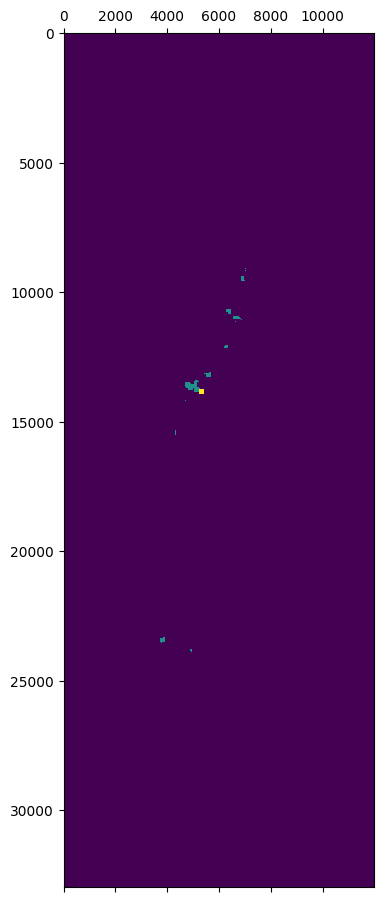

In [ ]:
regenerated_mask_llp = regenerate_mask_llp(df_patch)
regenerated_mask_llp = cv2.GaussianBlur(regenerated_mask_llp,(31,31), 0)
plt.matshow(regenerated_mask_llp)

### Get thumbnail and mask

In [ ]:
def get_mask(slide):
  mask = openslide.OpenSlide(os.path.join(mask_folder, f"{slide}_mask.tiff"))
  mask_data = mask.read_region((0,0), 0, mask.level_dimensions[0])
  mask_data = mask_data.split()[0]
  mask.close()
  return np.asarray(mask_data)


In [ ]:
thumb, mask = get_thumbnail(img_name), get_mask(img_name)

### Resize generated mask to match ground truth mask

In [ ]:
mask.shape

(23296, 11776)

In [ ]:
resized_generated_mask_kqm = cv2.resize(regenerated_mask_kqm, (mask.shape[1], mask.shape[0]), interpolation = cv2.INTER_CUBIC)
resized_generated_mask_nn = cv2.resize(regenerated_mask_nn, (mask.shape[1], mask.shape[0]), interpolation = cv2.INTER_CUBIC)
resized_generated_mask_llp = cv2.resize(regenerated_mask_llp, (mask.shape[1], mask.shape[0]), interpolation = cv2.INTER_CUBIC)


In [ ]:
def overlay_mask_on_wsi(slide_data, mask_data):
  wsi = openslide.OpenSlide(os.path.join(image_folder, f"{slide_data}.tiff"))
  slide_data = wsi.read_region((0,0), 0, wsi.level_dimensions[0])
  alpha = 1
  alpha_int = int(round(255*alpha))

  alpha_content = np.less(mask_data, 2).astype('uint8') * alpha_int + (255 - alpha_int)

  alpha_content = Image.fromarray(alpha_content)
  preview_palette = np.zeros(shape=768, dtype=int)

# Mapping: {0: background, 1: stroma, 2: benign epithelium, 3: Gleason 3, 4: Gleason 4, 5: Gleason 5}
  preview_palette[0:18] = (np.array([0, 0, 0, 0, 0.2, 0, 0, 1, 0, 1, 1, 0.7, 1, 0.5, 0, 1, 0, 0]) * 255).astype(int)
  mask_data = Image.fromarray(mask_data)
  mask_data.putpalette(data=preview_palette.tolist())
  mask_rgb = mask_data.convert(mode='RGB')
  print(slide_data.size, mask_rgb.size)
  wsi_mask_overlay = PIL.Image.composite(image1=slide_data, image2=mask_rgb, mask=alpha_content)
  wsi_mask_overlay.save(f'/content/{img_name}_with_mask_kqm.png')
  return wsi_mask_overlay


In [ ]:
slide_with_pred_mask_kqm = overlay_mask_on_wsi(img_name, resized_generated_mask_kqm)

(11776, 32768) (11776, 32768)


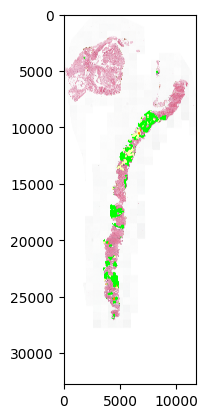

In [ ]:
plt.imshow(slide_with_pred_mask_kqm)

In [ ]:
slide_with_pred_mask_nn = overlay_mask_on_wsi(img_name, resized_generated_mask_nn)

(4608, 26368) (4608, 26368)


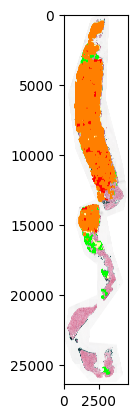

In [ ]:
plt.imshow(slide_with_pred_mask_nn)

In [ ]:
def overlay_gg_mask_on_wsi(slide_data, mask_data):
    wsi = openslide.OpenSlide(os.path.join(image_folder, f"{slide_data}.tiff"))
    slide_data = wsi.read_region((0, 0), 0, wsi.level_dimensions[0])
    alpha = 1
    alpha_int = int(round(255 * alpha))

    alpha_content = np.less(mask_data, 2).astype('uint8') * alpha_int + (255 - alpha_int)

    alpha_content = Image.fromarray(alpha_content)
    preview_palette = np.zeros(shape=768, dtype=int)

    # Mapping: {0: gg0, 1: gg1, 2: gg2, 3: gg3, 4: gg4, 5: gg5}
    preview_palette[3:21] = (np.array([0, 0.5, 0, 0, 1, 0, 1, 1, 0, 1, 0.5, 0, 1, 0, 0, 1, 0, 0]) * 255).astype(int)
    mask_data = Image.fromarray(mask_data)
    mask_data.putpalette(data=preview_palette.tolist())
    mask_rgb = mask_data.convert(mode='RGB')
    print(slide_data.size, mask_rgb.size)
    wsi_mask_overlay = PIL.Image.composite(image1=slide_data, image2=mask_rgb, mask=alpha_content)
    wsi_mask_overlay.save(f'/content/{img_name}_with_mask_llp.png')
    return wsi_mask_overlay

In [ ]:
slide_with_pred_mask_llp = overlay_gg_mask_on_wsi(img_name, resized_generated_mask_llp)

(11776, 32768) (11776, 32768)


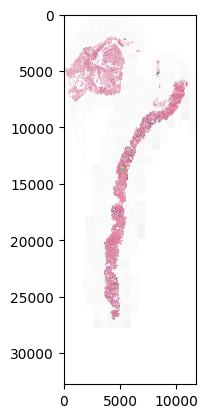

In [ ]:
plt.imshow(slide_with_pred_mask_llp)

# KQR Tissue Highlighting

### Copy features

In [ ]:
print("[INFO] Copying features in instance")
start = time.time()
!cp /content/drive/MyDrive/data/kqm_data/train_features.zip /content/
!cp /content/drive/MyDrive/data/kqm_data/val_features.zip /content/
!cp /content/drive/MyDrive/data/kqm_data/test_features.zip /content/
print("[INFO] Extracting...")
!unzip /content/train_features.zip -d /content/
!unzip /content/val_features.zip -d /content/
!unzip /content/test_features.zip -d /content/
end = time.time()


print(f"Features extraction in instance took: {end - start} seconds")